<a href="https://colab.research.google.com/github/angulartist/Deep-Learning-AnyPercent/blob/master/kaggle/mnist/mnist_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
# Colab magic.
%tensorflow_version 1.x 

import tensorflow as tf
# Check if we're using a GPU.
print(tf.test.gpu_device_name())

import os

from google.colab import drive

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

matplotlib.use('Agg')  
plt.style.use('seaborn-dark')
%matplotlib inline

/device:GPU:0


# Setup

In [99]:
''' Authorize Google Colab to have access to your Drive '''

drive.mount('/content/gdrive', force_remount=True)
root_dir  = '/content/gdrive/My Drive/'
workspace = 'deepl/'
base_dir  = os.path.join(root_dir, workspace)

print('Working on:', base_dir)

Mounted at /content/gdrive
Working on: /content/gdrive/My Drive/deepl/


In [0]:
# Some variables

dimensions    = 28 # (28x28)
num_channels  = 1  # Gray-scale
num_classes   = 10 # 0 to 9

# Load the MNIST dataset from Keras

In [0]:
'''
Download the MNSIT dataset from Keras.

We get back two tuple pairs, each containing
image samples and their related labels, for the train set
and the test set.
'''

(X_train, y_train), (X_ttest, y_ttest) = mnist.load_data()

In [102]:
'''
Each sample is a 28x28 image with 1 channel/depth (gray-scale).

The train set holds 60000 samples, whereas the test set
handles 10000 samples.
'''

print('Train set shape:', X_train.shape)
print('Test  set shape:', X_ttest.shape)

Train set shape: (60000, 28, 28)
Test  set shape: (10000, 28, 28)


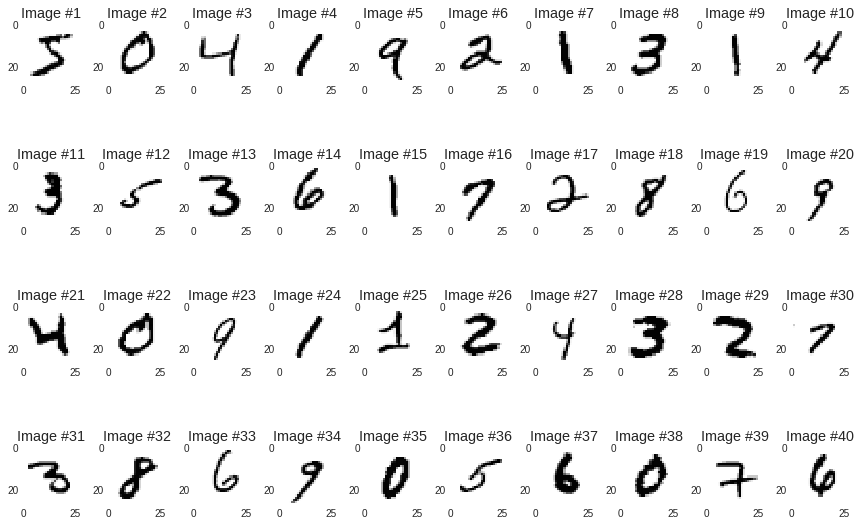

In [103]:
'''
As you can see, images in the MNIST dataset are heavily pre-processed.

That's why it's used as a benchmark dataset and you can expect getting some high accuracy
why any basic CNN.
'''

fig, ax = plt.subplots(
    nrows=4,
    ncols=10,
    figsize=[12, 8]
)

for index, axi in enumerate(ax.flat):
    axi.imshow(X_train[index])
    axi.set_title(f'Image #{index + 1}')

plt.tight_layout(True)
plt.show()

# Data enrichment

In [104]:
'''
60000 training samples is great.

But you can easily over-fit the model
and not be able to get a higher accuracy.
That's why we'll combine the Keras MNIST training set
with the training dataset you can find in the Kaggle competition.

https://www.kaggle.com/c/digit-recognizer/
'''

# Load the Kaggle training set.
X_df = pd.read_csv(os.path.join(base_dir, 'train.csv.zip'))

'''
There are 42000 rows corresponding to 42000 training samples.
For each row, the first column holds the ground truth label,
and the next 784 rows are the raw pixel intensities in the range [0, 255]
which is gray-scale.
'''
print('Kaggle train set shape:', X_df.shape)
X_df.head()

Kaggle train set shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
'''
We must separate the pixel intensities
from their related labels.
'''

# Extract the pixel intensities.
X = X_df.iloc[:, 1:]
X = X.values

# Extract the labels.
y = X_df.iloc[:, 0]
y = y.values

'''
As for the training set labels,
there is one numeric label for each sample.
'''
pd.DataFrame(y)

,0
0,1
1,0
2,1
3,4
4,0
...,...
41995,0
41996,1
41997,7
41998,6


# Reshape datasets

In [106]:
'''
To be able to train a model with this dataset,
we first need to reshape both the train set and the test set
that way the number of samples is the first entry in the matrix,
the single channel as the second entry, followed by the number of rows and columns.

(num_samples, rows, columns, channel)
'''

X_train = X_train.reshape(-1, D, D, C)
X_ttest = X_ttest.reshape(-1, D, D, C)

print('Train set shape:', X_train.shape)
print('Test  set shape:', X_ttest.shape)

Train set shape: (60000, 28, 28, 1)
Test  set shape: (10000, 28, 28, 1)


In [123]:
'''
Now, we're going to concatenate the train set
we got from Keras with the dataset we've downloaded
from the Kaggle competition.

Let's reshape it too.
'''

X = X.reshape(-1, D, D, C)

print('Train alt set shape:', X.shape)

Train alt set shape: (42000, 28, 28, 1)


In [108]:
'''
Calling np.concatenate will produce
a numpy array representing 102000 training samples
of 28x28x1 dimension and a numpy array
containing 102000 labels.
'''

X_train = np.concatenate((X_train, X), axis=0)
y_train = np.concatenate((y_train, y), axis=0)

print('Final train set shape:', X_train.shape)
print('Final train labels:', y_train.shape)

Final train set shape: (102000, 28, 28, 1)
Final train labels: (102000,)


# Normalize pixel intensities to range [0, 1]

In [0]:
'''
Normalization of pixel intensities is adjusting values measured on different scales
to a notionally common scale. That's a best practice you have to follow because weights
reach optimum values faster. Therefore, the network converges faster.

So, instead of having pixel intensities in the range [0, 255] in the gray-scale color-space,
we're going to scale them into the range [0, 1].

There are many normalization techniques and this is one of them.
'''

(X_train, X_ttest) = (child.astype('float32') / 255.0 for child in [X_train, X_ttest])

# One-Hot Encode labels


In [110]:
'''
Now, our previous integer labels are converted to vector labels.
This process is called one-hot encoding and most of the machine learning algorithms
benefit from this label representation. 2 = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
8 = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0].

Imagine that you have 3 categories: Cat, Dog, and Lama.
We first need to convert them to numeric values 1, 2 and 3
so our algorithm is able to do its work.

But, giving these values to the algorithm will lead to mistakes.
In fact, there is no relationship between these categories,
and you algorithm may try to compute the average and...
the average of Cat, Dog, and Lama has no sens. The opposite
example would be Cold, Warm, Hot, Very Hot.

That's why we have to use one-hot encoding.

We could also use the to_categorical() function from Keras which yields the exact same values.
'''

lb = LabelBinarizer()
(y_train, y_ttest) = (lb.fit_transform(labels) for labels in [y_train, y_ttest])
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
101995,1,0,0,0,0,0,0,0,0,0
101996,0,1,0,0,0,0,0,0,0,0
101997,0,0,0,0,0,0,0,1,0,0
101998,0,0,0,0,0,0,1,0,0,0


# Data Augmentation

In [0]:
'''
Let's apply some data augmentation.

Data augmentation is a set of techniques used to generate new training samples from the original ones
by applying jitters and perturbations such that the classes labels are not changed.
In the context of computer vision, these random transformations can be translating,
rotating, scaling, shearing, flipping etc.

Data augmentation is a form of regularization because the training algorithm is being
constantly presented with new training samples,
allowing it to learn more robust and discriminative patterns
and reducing overfitting.
'''

daug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# Build the model

In [0]:
'''
Here, we've imported our CNN.

Pay attention to Batch Normalization and Dropout layers
which help to reduce overfitting.
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization,
                                     Conv2D,
                                     MaxPooling2D,
                                     Activation,
                                     Flatten,
                                     Dropout,
                                     Dense,
                                     LeakyReLU)

class CustomNet(object):
    @staticmethod
    def build(width, height, num_classes, depth=3):
        model = Sequential()
        input_shape = (height, width, depth)
        chan_dim = -1
        
        model.add(Conv2D(64, (5, 5), padding='same', input_shape=input_shape))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (5, 5), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Softmax
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
        
        print(model.summary())
        
        return model

In [113]:
net = CustomNet()

model = net.build(
    width=D,
    height=D,
    num_classes=P,
    depth=C)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)       

In [0]:
'''
When the model has seen all of your training samples, we say that one epoch has passed.
We're going to train the model for N epochs.
'''

num_epochs = 50

# Set the optimizer and hyperparameters

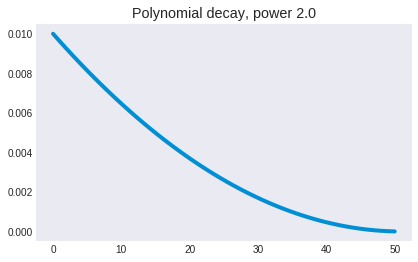

In [115]:
'''
Let's use an optimization method.

Optimization algorithms are the engines that power neural networks and
enable them to learn patterns from data by tweaking and seeking for optimal weights values.
Most common one is the (Stochastic) Gradient Descent, but I'll use Adam here.

As you can see, the first param is lr, or learning rate.
This is one of the most important hyperparameters we have to tune.
A learning rate is the step your optimization algorithm is going to make toward
the direction that leads to a lower loss function (and a higher accuracy).

If the learning rate is too small, the algorithm is going to make tiny steps slowing down the process.
But on the other hand, if the learning rate is too high,
the algorithm risks to bounce around the loss landscape and not actually “learn” any patterns from your data.
'''

# Initial learning rate.
init_lr = 0.01

adam_opt = Adam(
    lr=init_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    decay=0.0
)


'''
Let's now define a learn-rate scheduler.

The decay is used to slowly reduce the learning rate over time.
Decaying the learning rate is helpful in reducing overfitting 
and obtaining higher classification accuracy – the smaller the learning rate is, 
the smaller the weight updates will be. 
'''

# Example 1: Polynomial decay.
def polynomial_decay(epoch):
    max_epochs = num_epochs
    base_lr = init_lr
    power = 2.0
    
    return base_lr * (1 - (epoch / float(max_epochs))) ** power

# Plot.
x = np.linspace(0, num_epochs)
fx = [init_lr * (1 - (i / float(num_epochs))) ** 2.0 for i in range(len(x))]
plt.plot(x, fx)
plt.title(label='Polynomial decay, power 2.0')
plt.show()

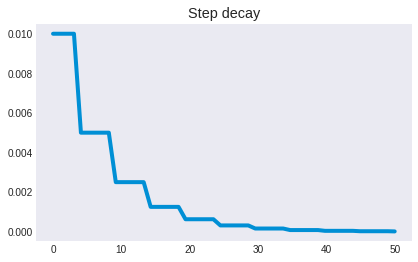

In [116]:
# Example 2: Step-based decay.
def step_decay(epoch):
  factor    = 0.5
  drop_rate = 5

  return float(init_lr * (factor ** np.floor((1 + epoch) / drop_rate)))

# Plot.
x = np.linspace(0, num_epochs)
fx = [float(init_lr * (0.5 ** np.floor((1 + i) / 5))) for i in range(len(x))]
plt.plot(x, fx)
plt.title(label=f'Step decay')
plt.show()

# Training time!

In [0]:
'''
Callback are functions called at the end of an epoch.
We must pass our custom learning rate decay into
the callbacks array.
'''

# (Optional) Saving best weights values.
checkpointHandler = ModelCheckpoint(
    os.path.join(base_dir, 'best_c10_weights.hdf5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Callbacks array.
callbacks = [
    LearningRateScheduler(step_decay) # <- Using step decay.
    # checkpointHandler
]

In [118]:
'''
Instead of updating our weights after each epoch,
which is slow and computationally wasteful,
we'll update them for each mini-batch of samples.
'''
batch_size = 128

model.compile(
    loss='categorical_crossentropy',
    optimizer=adam_opt,
    metrics=['accuracy']
)

print('# Training the network...')
h = model.fit_generator(
    daug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_ttest, y_ttest),
    epochs=num_epochs,
    steps_per_epoch=len(X_train) // batch_size,
    callbacks=callbacks,
    verbose=1
)

# Training the network...
Epoch 1/50
796/796 [==============================] - 33s 41ms/step - loss: 0.1679 - acc: 0.9500 - val_loss: 0.0488 - val_acc: 0.9854
Epoch 2/50
796/796 [==============================] - 31s 39ms/step - loss: 0.0711 - acc: 0.9792 - val_loss: 0.0396 - val_acc: 0.9882
Epoch 3/50
796/796 [==============================] - 31s 39ms/step - loss: 0.0561 - acc: 0.9838 - val_loss: 0.0374 - val_acc: 0.9895
Epoch 4/50
796/796 [==============================] - 31s 39ms/step - loss: 0.0515 - acc: 0.9847 - val_loss: 0.0229 - val_acc: 0.9931
Epoch 5/50
796/796 [==============================] - 31s 39ms/step - loss: 0.0327 - acc: 0.9906 - val_loss: 0.0212 - val_acc: 0.9936
Epoch 6/50
796/796 [==============================] - 31s 39ms/step - loss: 0.0319 - acc: 0.9907 - val_loss: 0.0187 - val_acc: 0.9940
Epoch 7/50
796/796 [==============================] - 31s 39ms/step - loss: 0.0324 - acc: 0.9903 - val_loss: 0.0142 - val_acc: 0.9960
Epoch 8/50
796/796 [================

# Confusion matrix

In [119]:
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

print('Confusion matrix:')
preds = model.predict(X_ttest, batch_size=batch_size)
print(classification_report(y_ttest.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

Confusion matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



# Visualize curves

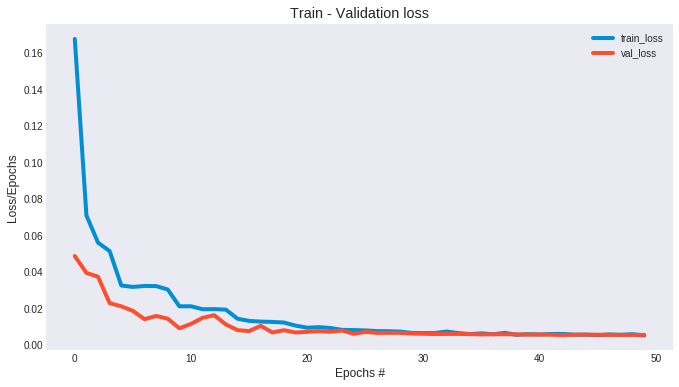

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')

plt.title('Train - Validation loss')
plt.ylabel('Loss/Epochs')
plt.xlabel('Epochs #')
plt.legend()

plt.show()

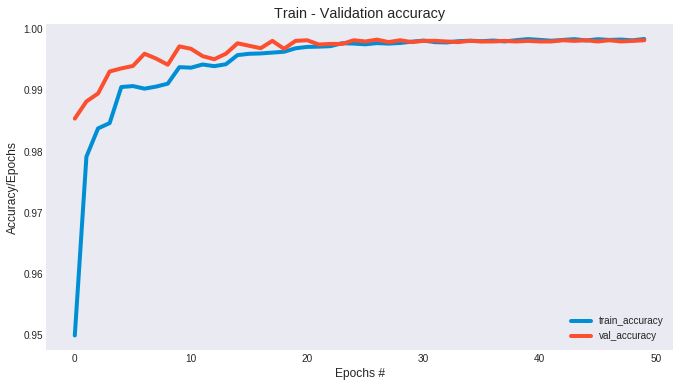

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, num_epochs), h.history['acc'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), h.history['val_acc'], label='val_accuracy')

plt.title('Train - Validation accuracy')
plt.ylabel('Accuracy/Epochs')
plt.xlabel('Epochs #')
plt.legend()

plt.show()

# Kaggle

In [122]:
'''
Pushing a submission to Kaggle.

First of, load the test set, normalize it and reshape it.
Then, make predictions via the trained model and build the
submission csv file.
'''

sub_X_test = pd.read_csv(os.path.join(base_dir, 'test.csv'))     # load test csv into DataFrame
sub_X_test = sub_X_test / 255.0                                  # normalize pixel itensities
sub_X_test = sub_X_test.values.reshape(-1, D, D, C)              # reshape to meet Keras requirements
preds = model.predict_classes(sub_X_test, batch_size=batch_size) # make predictions
id_col = np.arange(1, preds.shape[0] + 1)                        # shift index
submission = pd.DataFrame({'ImageId': id_col, 'Label': preds})   # build a submission                                     
print(submission.head(20))
submission.to_csv(os.path.join(base_dir, 'cnn_mnist_datagen.csv'), index=False)

print('Saved to:', os.path.join(base_dir, 'cnn_mnist_datagen.csv'))

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      0
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0
Saved to: /content/gdrive/My Drive/deepl/cnn_mnist_datagen.csv
